**Modification to always satisfy the RH-constraint**

In [3]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '../sec2_data')
from functions import append_dict_to_json
from sklearn import tree

np.random.seed(10)

In [4]:
def round_expr(expr):
    d = {}
    for n in expr.atoms(sp.Number):
        d[n] = sp.Number('%.6g'%n)
    return expr.xreplace(d)

In [5]:
no_of_regimes = 2
regime = 1

**Read data**

In [6]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
    
# Features
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
no_features = len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [8]:
path_data = os.path.join(os.environ['HOME'] + 'my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

# Load the input data and pick the five best features (rh, ta, clw, cli, rh_z)
input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc_all[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [10]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 5)

In [11]:
# Construct training and validation data
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

In [12]:
# The second fold yields the best model
flattened_input_train = input_data[training_folds[1]]
flattened_input_valid = input_data[validation_folds[1]]
flattened_output_train = output_data[training_folds[1]]
flattened_output_valid = output_data[validation_folds[1]]
    
# Remove input_data, output_data
del input_data, output_data, training_folds, validation_folds
gc.collect()

836

In [13]:
if no_of_regimes > 1:
    # Already remove the regime with clw + cli = 0
    reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] > 1e-20)[0]
    flattened_input_train = flattened_input_train[reg_not_0_train]
    flattened_output_train = flattened_output_train[reg_not_0_train]

    reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] > 1e-20)[0]
    flattened_input_valid = flattened_input_valid[reg_not_0_valid]
    flattened_output_valid = flattened_output_valid[reg_not_0_valid]

**Normalize the features**

In [14]:
# Scale the data
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

# Work with scaled training folds
train_data_scaled = (flattened_input_train - mean)/std
valid_data_scaled = (flattened_input_valid - mean)/std

**The condition for the artificial increase of RH**

In [15]:
x0, x1 = sp.symbols('x0 x1')
rh, ta = sp.symbols('rh ta')

(a,b,c,d) = (38.6562122, 43.53500518, 19.78403208, 1.13637902)

cond = 1/(2*c*d)*(-c*x1**2-a) - x0

X0 = (rh - mean_all[loc_all['rh']])/std_all[loc_all['rh']]
X1 = (ta - mean_all[loc_all['ta']])/std_all[loc_all['ta']]

subs_set = []
for k in range(2):
    subs_set.append((locals()['x%d'%k], globals()['X%d'%k]))
subs_set = set(subs_set)
cond_orig_inputs = cond.subs(subs_set)

print('If the following term is greater than 0, then RH is increased:')
round_expr(cond_orig_inputs)

If the following term is greater than 0, then RH is increased:


-3.00757*rh - 32.192*(0.00389006*ta - 1)**2 + 0.952388

In [16]:
print('That means whenever RH < 0.3269 - 10.5359*(0.00389006*T-1)^2')

That means whenever RH < 0.3269 - 10.5359*(0.00389006*T-1)^2


In [17]:
sp.expand('0.3269 - 10.5359*(0.00389006*T-1)**2')

-0.000159435210586049*T**2 + 0.081970566308*T - 10.209

In [18]:
np.sqrt(10.5359)

3.2459051125995657

In [19]:
np.sqrt(10.5359)*0.00389006

0.012626765642319066

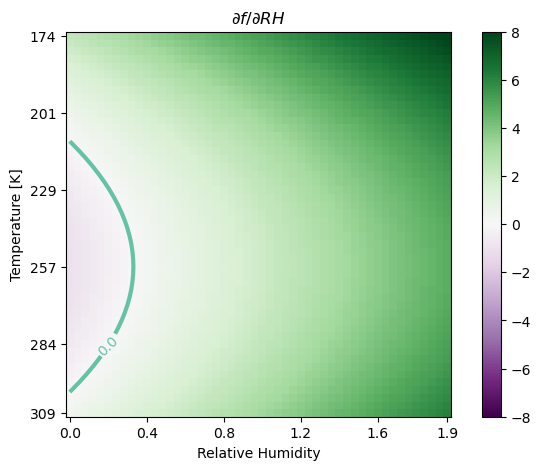

In [12]:
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from matplotlib import colors

fig = plt.figure(figsize=(8, 5))

# Define the bounds
rh_min = np.min(flattened_input_train[:, loc['rh']])
rh_max = np.max(flattened_input_train[:, loc['rh']])
ta_min = np.min(flattened_input_train[:, loc['ta']])
ta_max = np.max(flattened_input_train[:, loc['ta']])

# Number of pixels in x- and y-direction
N_x = 50
N_y = 50
 
x = np.linspace(rh_min, rh_max, N_x)
y = np.linspace(ta_min, ta_max, N_y)
X,Y = meshgrid(x, y)

Z = -(-3.00757*X-31.6875*(0.00389006*Y-1)**2+0.983277)

ax = plt.subplot(111, xticks=[0,10,20,30,40,49], yticks=[0,10,20,30,40,49])
ax.set_xticklabels(['%.1f'%val for val in [x[0],x[10],x[20],x[30],x[40],x[49]]])
ax.set_yticklabels(['%d'%val for val in [y[0],y[10],y[20],y[30],y[40],y[49]]])

# plt.xticks(np.arange(0, N_x, N_x/5), ['%.1f'%val for val in np.linspace(min(x), max(x), 5)])
# plt.yticks(np.arange(0, N_y, N_y/5), ['%d'%val for val in np.linspace(min(y), max(y), 5)])

plt.title('$\partial f/\partial RH$')

im = ax.imshow(Z, cmap='PRGn', vmin=-8, vmax=8) 
cset = ax.contour(Z, [0], linewidths=3,cmap=cm.Set2)
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
colorbar(im)

plt.xlabel('Relative Humidity')
plt.ylabel('Temperature [K]')
plt.savefig('derivative_of_f_wrt_rh.pdf')

In [121]:
T_opt = 1/0.00389006
cond_max = -31.6875*(0.00389006*T_opt-1)**2+0.983277
rh_max_increase = cond_max/3.00757

print(cond_max)
print(rh_max_increase)

0.983277
0.3269340364480295


In [130]:
print('The condition can only trigger for T between %.3f and %.3f.'%((-np.sqrt(0.98/31.6875) + 1)/0.00389, (np.sqrt(0.98/31.6875) + 1)/0.00389))
print('The condition sets RH to be at least 0.3269 - 10.5359(0.00389T - 1)^2 (which decreases cloud cover)')
print('The condition is most active for T = 257.0654 and RH = 0. It then sets RH to 0.3269.')

The condition can only trigger for T between 211.861 and 302.278.
The condition sets RH to be at least 0.3269 - 10.5359(0.00389T - 1)^2 (which decreases cloud cover)
The condition is most active for T = 257.0654 and RH = 0. It then sets RH to 0.3269.


Optimize coefficients

In [38]:
# See ~/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/notes.txt
def func(X, a,b,c,d,e,f,g,h,i,j):
    x0 = X[:, 0] 
    x1 = X[:, 1] 
    x2 = X[:, 2] 
    x3 = X[:, 3]
    x4 = X[:, 4]
    
    # Modified to always satisfy RH-constraint
    x0 = np.maximum(x0, 1/(2*c*d)*(-c*x1**2-a))
    
    return a*x0 - b*x1 + c*x0*(d*x0 + x1**2) + x4**2*(e*x4 + f) + g - h/(x2 + i*x3 + j)

In [39]:
import scipy as sci
from scipy.optimize import minimize

In [40]:
def objective(P, X,Y):
    '''
        The objective function.
    '''
    a,b,c,d,e,f,g,h,i,j = P
    train_preds = np.minimum(np.maximum(func(X, a,b,c,d,e,f,g,h,i,j), 0), 100) 
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)

    return train_mse

T_subset = 10**6
inds = np.random.randint(0, train_data_scaled.shape[0], T_subset)

(a,b,c,d,e,f,g,h,i,j) = (36.69, 36.69, 16.48, 1, 0.21, 2.76, 50.29, 2.86, 1, 0.76)

# Nelder-Mead gives me the same result
res = minimize(objective, (a,b,c,d,e,f,g,h,i,j), args=(train_data_scaled[inds], flattened_output_train[inds]), \
               method='BFGS', options={'disp': True})

         Current function value: 158.700476
         Iterations: 30
         Function evaluations: 484
         Gradient evaluations: 44


In [41]:
print(res.x)

[38.15388776 43.63539083 19.93732831  1.15446879  0.35551696  4.06188388
 44.23799326  2.03600412  0.66480254  0.63943517]


New values

In [42]:
objective(res.x, train_data_scaled, flattened_output_train)

159.23523622241254

In [43]:
objective(res.x, valid_data_scaled, flattened_output_valid)

157.60467889204403

In [48]:
# From finding_symmetries/pysr_results_dyamond_on_regimes/save_optimized_eqns.ipynb
mse_reg_0 = 0.0353
n_0 = 32419018
n_21 = 62640812
N = n_0 + n_21

valid_reg_mse = 157.60467889204403

print('On the entire dataset')
print('Valid MSE: %.5f'%((n_0*mse_reg_0 + n_21*valid_reg_mse)/N))

On the entire dataset
Valid MSE: 103.86753


In [49]:
objective([38.6562122, 43.53500518, 19.78403208, 1.13637902, 0.35299939, 4.04888686, 44.21730274, 2.03128527, 0.66971589, 0.6409019 ], \
          valid_data_scaled, flattened_output_valid)

157.63718734237756

In [50]:
# From finding_symmetries/pysr_results_dyamond_on_regimes/save_optimized_eqns.ipynb
mse_reg_0 = 0.0353
n_0 = 32419018
n_21 = 62640812
N = n_0 + n_21

valid_reg_mse = 157.63718734237756

print('On the entire dataset')
print('Valid MSE: %.5f'%((n_0*mse_reg_0 + n_21*valid_reg_mse)/N))

On the entire dataset
Valid MSE: 103.88895


How often do we need to artificially increase the RH?

In [45]:
# Optimal params without the RH-modification
(a,b,c,d) = (38.6562122, 43.53500518, 19.78403208, 1.13637902)

# In roughly 1% of all cases
len(np.where(train_data_scaled[:, 0] < 1/(2*c*d)*(-c*train_data_scaled[:, 1]**2-a))[0])/len(train_data_scaled[:, 0])

0.009560125771782007

In [47]:
# Optimal params with the RH-modification
(a,b,c,d) = (38.15388776, 43.63539083, 19.93732831, 1.15446879)

# In roughly 1% of all cases
len(np.where(train_data_scaled[:, 0] < 1/(2*c*d)*(-c*train_data_scaled[:, 1]**2-a))[0])/len(train_data_scaled[:, 0])

0.010437487368024214